In [236]:
import numpy as np
import pandas as pd
import pickle

In [237]:
with open('0306_dataset.pickle', 'rb') as handle:
    raw_data,prepare_training = pickle.load(handle)
    
with open('0326_predData.pickle', 'rb') as handle:
    stock_score,stock_pred,max_precision = pickle.load(handle)

In [238]:
import sklearn.metrics as met
import lightgbm as lg
import xgboost as xgb

# 모델링

In [239]:
# stock_pred = {}

# main_epoc = pd.DataFrame()
# for stock in raw_data.keys():
#     i = int(max_precision['number'].loc[stock])
#     main_epoc = pd.DataFrame()
#     for j in np.arange(1,90,3):
#         column_list = []
#         for col in prepare_training[stock]['Y2_{:02}_{:02}'.format(i,j)].keys():
#             column_list.append(col)
#         lgbm = lg.LGBMRegressor(random_state=0,n_jobs=-1)
#         X_train = raw_data[stock][column_list][:'2017-06-30']
#         y_train = raw_data[stock]['Y2_{:02}_{:02}'.format(i,j)][:'2017-06-30']
#         X_test = raw_data[stock][column_list]['2017-06-30':'2018-06-30']
#         y_test = raw_data[stock]['Y1_{:02}'.format(i)]['2017-06-30':'2018-06-30']
#         lgbm.fit(X_train, y_train)
#         over_term_pred = pd.concat([X_train['2017-01-01':],X_test['2017-06-30':'2018-06-30']],axis=0)
#         a = lgbm.predict(over_term_pred)
#         a =  np.where(a > 0,1,0)
#         epoc_series = pd.DataFrame(a, columns = ['{}_pred'.format(j)], index = over_term_pred.index)
#         main_epoc = pd.concat([main_epoc,epoc_series],axis=1)
#     stock_pred[stock] = main_epoc

In [240]:
stock_train_pred = {}
stock_pred_pram = {}


for stock in raw_data.keys():
    main_epoc = pd.DataFrame()
    main_epoc2 = pd.DataFrame()
    for i in np.arange(1,90,3):
        for j in np.arange(1,90,3):
            column_list = []
            for col in prepare_training[stock]['Y2_{:02}_{:02}'.format(i,j)].keys():
                column_list.append(col)
            lgbm = xgb.XGBRegressor(random_state=0,n_jobs=-1)
            X_train = raw_data[stock][column_list][:'2017-06-30']
            y_train = raw_data[stock]['Y2_{:02}_{:02}'.format(i,j)][:'2017-06-30']
            X_test = raw_data[stock][column_list]['2017-06-30':'2018-06-30']
            y_test = raw_data[stock]['Y1_{:02}'.format(i)]['2017-06-30':'2018-06-30']
            lgbm.fit(X_train, y_train)
            a = lgbm.predict(pd.concat([X_train['2017-01-01':'2017-06-29'],X_test['2017-06-30':'2018-06-30']],axis=0))
            a =  np.where(a > 0,1,0)
            b = lgbm.predict(X_train[:'2017-06-30'])
            b =  np.where(b > 0,1,0)
            epoc_series = pd.DataFrame(a, columns = ['{}_{}_pred'.format(i,j)], index = raw_data[stock].loc['2017-01-01':'2018-06-30'].index)
            epoc_series2 = pd.DataFrame(b, columns = ['{}_{}_pred'.format(i,j)], index = raw_data[stock].loc[:'2017-06-30'].index)
            main_epoc = pd.concat([main_epoc,epoc_series],axis=1)
            main_epoc2 = pd.concat([main_epoc2,epoc_series2],axis=1)
    stock_pred_pram[stock] = main_epoc
    stock_train_pred[stock] = main_epoc2

In [241]:
precision_dict = {}
for stock in raw_data.keys():
    stock_df = pd.DataFrame(columns = ['{}_fir'.format(i) for i in np.arange(1,90,3)],
                            index = ['{}_sec'.format(i) for i in np.arange(1,90,3)])

    for i in np.arange(1,90,3):
        for j in np.arange(1,90,3):
            a = stock_train_pred[stock]['{}_{}_pred'.format(i,j)]
            stock_df['{}_fir'.format(i)].loc['{}_sec'.format(j)] = met.precision_score(np.where(raw_data[stock]['Y1_{:02}'.format(i)].loc[a.index] > 0,1,0),a, labels=[1,0])
            
    precision_dict[stock] = stock_df

In [242]:
max_precision_df = pd.DataFrame(index = ['{}_fir'.format(i) for i in np.arange(1,90,3)], columns = raw_data.keys())


for stock in raw_data.keys():
    for i in np.arange(1,90,3):
        max_precision_df[stock]['{}_fir'.format(i)] = precision_dict[stock]['{}_fir'.format(i)].mean()

In [243]:
max_precision_stock = {}
for stock in raw_data.keys():
    for i in max_precision_df[stock].index:
        if max_precision_df[stock].loc[i] == max_precision_df[stock].max():
            max_precision_stock[stock] = i

# 계산식

In [244]:
# 일단 1로 분류된거를 찾고나서 이거에 대한 최근 90일동안의 precision을 측정
# moving average에 관해서 일부만 사용? term을 늘려서 해보기
# precision이 높았던걸로 투자를 한 것들에서

In [245]:
def transaction(stock, pred, term1):
    tran_table = pd.DataFrame(columns = ['profit'])
    now_index = 0
    tran_table.loc['2017-06-30'] = 0
    while now_index <= len(pred):
        if pred.iloc[now_index] > 0:
            tran_table.loc[pred.index[now_index+term1]] = np.log(raw_data[stock]['Close'].loc[pred.index[now_index+term1]]/raw_data[stock]['Close'].loc[pred.index[now_index]])
            now_index = now_index + term1
        else:
            now_index = now_index + 1

        if now_index + term1 >= len(pred):
            break

    tran_table = tran_table+1
    tran_table = tran_table.cumprod()
    
    return tran_table

In [246]:
#(true, pred, labels=[1,0]) 적용시켜야함

# for stock in raw_data.keys():
#     i = int(max_precision_stock[stock][:2])
#     stock_pred_copy = stock_pred_pram[stock].copy()
#     for j in np.arange(1,90,3):

#         raw_Y = raw_data[stock]['Y1_{:02}'.format(int(max_precision['number'][stock]))]
#         raw_Y = raw_Y[stock_pred_pram[stock].index]
#         real_Y = pd.DataFrame(np.where(raw_Y > 0,1,0), index = raw_Y.index, columns = [raw_Y.name])

#         column_list = []
#         for col in prepare_training[stock]['Y2_{:02}_{:02}'.format(i,j)].keys():
#             column_list.append(col)

#         xgboost_model = xgb.XGBRegressor(random_state=0,n_jobs=-1)
#         X_train = raw_data[stock][column_list][:'2017-06-30']
#         y_train = raw_data[stock]['Y2_{:02}_{:02}'.format(i,j)][:'2017-06-30']
#         xgboost_model.fit(X_train, y_train)
#         train_pred = xgboost_model.predict(raw_data[stock][column_list][:'2017-06-30'])
#         main_score = met.precision_score(np.where(train_pred > 0,1,0), np.where(raw_data[stock]['Y1_{:02}'.format(i)][:'2017-06-30'] > 0,1,0))

#         k = 0
#         while 90 + k <= len(raw_Y):
#             if met.precision_score(stock_pred_copy['{}_{}_pred'.format(i,j)].iloc[k:90+k],real_Y.iloc[k:90+k]) < 0.5:
#                 stock_pred_pram[stock]['{}_{}_pred'.format(i,j)].iloc[89+k] = -1
                
#             elif met.precision_score(stock_pred_copy['{}_{}_pred'.format(i,j)].iloc[k:90+k],real_Y.iloc[k:90+k]) < main_score:
#                 stock_pred_pram[stock]['{}_{}_pred'.format(i,j)].iloc[89+k] = -1
#             k = k + 1

In [247]:
# votng_df = pd.DataFrame(index = stock_pred_pram[stock]['2017-06-30':].iloc[1:].index,columns = list(raw_data.keys()))

# for stock in raw_data.keys():
#     datas = stock_pred_pram[stock]['2017-06-30':].iloc[1:]
#     for ind in datas.index:
#         a = datas.loc[ind].values
#         if len(a[a >=0]) == 0:
#             votng_df[stock].loc[ind] = 0
        
#         elif a[a >= 0].sum()/len(a[a >= 0]) >= 0.5:
#             votng_df[stock].loc[ind] = 1
            
#         else:
#             votng_df[stock].loc[ind] = 0
            
# profit_dict = {}

# for stock in raw_data.keys():
#     pred = votng_df[stock]
#     i = int(max_precision_stock[stock][:2])
#     profit_dict[stock] = transaction(stock, pred, i)

#     indexing = []
#     for i in range(len(profit_dict[stock])):
#         indexing.append(str(profit_dict[stock].index[i])[:10])
#     profit_dict[stock].index = indexing
    
# profit_df = pd.DataFrame(columns = ['profit'])

# for stock in raw_data.keys():
#     profit_df.loc[stock] = float(profit_dict[stock].iloc[len(profit_dict[stock])-1])

# min_num test

In [248]:
stock_pred_main_copy = {}

for stock in raw_data.keys():
    stock_pred_main_copy[stock] = stock_pred_pram[stock].copy()

In [503]:
score_list = []

for min_num in [0.6,0.7,0.8,0.9]:

    for stock in raw_data.keys():
        stock_pred_pram[stock] = stock_pred_main_copy[stock].copy()
    
    
    for stock in raw_data.keys():
        i = int(max_precision_stock[stock][:2])
        stock_pred_copy = stock_pred_pram[stock].copy()
        for j in np.arange(1,90,3):

            raw_Y = raw_data[stock]['Y1_{:02}'.format(i)]
            raw_Y = raw_Y[stock_pred_pram[stock].index]
            real_Y = pd.DataFrame(np.where(raw_Y > 0,1,0), index = raw_Y.index, columns = [raw_Y.name])

            column_list = []
            for col in prepare_training[stock]['Y2_{:02}_{:02}'.format(i,j)].keys():
                column_list.append(col)

            xgboost_model = xgb.XGBRegressor(random_state=0,n_jobs=-1)
            X_train = raw_data[stock][column_list][:'2017-06-30']
            y_train = raw_data[stock]['Y2_{:02}_{:02}'.format(i,j)][:'2017-06-30']
            xgboost_model.fit(X_train, y_train)
            train_pred = xgboost_model.predict(raw_data[stock][column_list][:'2017-06-30'])
            main_score = met.precision_score(np.where(raw_data[stock]['Y1_{:02}'.format(i)][:'2017-06-30'] > 0,1,0),np.where(train_pred > 0,1,0), labels=[1,0])

            k = 0
            while 90 + k <= len(raw_Y):
                if met.precision_score(real_Y.iloc[k:90+k], stock_pred_main_copy[stock]['{}_{}_pred'.format(i,j)].iloc[k:90+k], labels=[1,0]) < 0.5:
                    stock_pred_pram[stock]['{}_{}_pred'.format(i,j)].iloc[89+k] = -1

                elif met.precision_score(real_Y.iloc[k:90+k], stock_pred_main_copy[stock]['{}_{}_pred'.format(i,j)].iloc[k:90+k], labels=[1,0]) < main_score*min_num:
                    stock_pred_pram[stock]['{}_{}_pred'.format(i,j)].iloc[89+k] = -1
                k = k + 1



    votng_df = pd.DataFrame(index = stock_pred_pram[stock]['2017-06-30':].iloc[1:].index,columns = list(raw_data.keys()))

    for stock in raw_data.keys():
        i = int(max_precision_stock[stock][:2])
        datas = stock_pred_pram[stock]['2017-06-30':][['{}_{}_pred'.format(i,j) for j in np.arange(1,90,3)]].iloc[1:]
        for ind in datas.index:
            a = datas.loc[ind].values
            
            if len(a[a >=0]) == 0:
                votng_df[stock].loc[ind] = 0

            elif a[a >= 0].sum()/len(a[a >= 0]) >= 0.5:
                votng_df[stock].loc[ind] = 1

            else:
                votng_df[stock].loc[ind] = 0

    profit_dict = {}

    for stock in raw_data.keys():
        pred = votng_df[stock]
        i = int(max_precision_stock[stock][:2])
        profit_dict[stock] = transaction(stock, pred, i)

        indexing = []
        for i in range(len(profit_dict[stock])):
            indexing.append(str(profit_dict[stock].index[i])[:10])
        profit_dict[stock].index = indexing

    profit_df = pd.DataFrame(columns = ['profit'])

    for stock in raw_data.keys():
        profit_df.loc[stock] = float(profit_dict[stock].iloc[len(profit_dict[stock])-1])
        
        
        
    score_list.append((min_num, profit_df['profit'].mean()))

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

In [504]:
votng_df = votng_df.fillna(0)

In [505]:
score_list

[(0.6, 1.1304801314909045),
 (0.7, 1.1340440943206485),
 (0.8, 1.1311394588007015),
 (0.9, 1.1350864900134823)]

In [295]:
score_df = pd.DataFrame(columns = ['profit','hold','precision','accuracy','max_number'])

for stock in raw_data.keys():
    i = int(max_precision_stock[stock][:2])
    raw_Y = raw_data[stock]['Y1_{:02}'.format(i)]
    raw_Y = raw_Y[stock_pred_main_copy[stock].index]
    real_Y = pd.DataFrame(np.where(raw_Y > 0,1,0), index = raw_Y.index, columns = [raw_Y.name])
    real_Y = real_Y.fillna(0)
    epoc_df1 = pd.DataFrame(columns = ['precision'])
    epoc_df2 = pd.DataFrame(columns = ['accuracy'])
    for j in np.arange(1,90,3):
        epoc_df1.loc[j] = met.precision_score(real_Y['Y1_{:02}'.format(i)].loc['2017-06-30':], stock_pred_main_copy[stock]['{}_{}_pred'.format(i,j)].loc['2017-06-30':], labels = [1,0])
        epoc_df2.loc[j] = met.accuracy_score(real_Y['Y1_{:02}'.format(i)].loc['2017-06-30':], stock_pred_main_copy[stock]['{}_{}_pred'.format(i,j)].loc['2017-06-30':])
    epoc_df3 = np.log(raw_data[stock]['Close'].loc['2018-05F-21']/raw_data[stock]['Close'].loc['2017-06-30']) + 1
    score_df.loc[stock] = [profit_df['profit'].loc[stock],epoc_df3,epoc_df1.mean()['precision'],epoc_df2.mean()['accuracy'],i]

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [293]:
votng_score_df = pd.DataFrame(columns = ['profit','hold','precision','accuracy','max_number'])

for stock in raw_data.keys():
    i = int(max_precision_stock[stock][:2])
    raw_Y = raw_data[stock]['Y1_{:02}'.format(i)]
    raw_Y = raw_Y[stock_pred_main_copy[stock].index]
    real_Y = pd.DataFrame(np.where(raw_Y > 0,1,0), index = raw_Y.index, columns = [raw_Y.name])
    real_Y = real_Y.fillna(0)

    epoc_df1= met.precision_score(real_Y['Y1_{:02}'.format(i)].loc['2017-07-03':],votng_df[stock].loc['2017-06-30':].loc[real_Y['Y1_{:02}'.format(i)].loc['2017-07-03':].index], labels=[1,0])
    epoc_df2 = met.accuracy_score(real_Y['Y1_{:02}'.format(i)].loc['2017-07-03':],votng_df[stock].loc['2017-06-30':].loc[real_Y['Y1_{:02}'.format(i)].loc['2017-07-03':].index])
    epoc_df3 = np.log(raw_data[stock]['Close'].loc['2018-05-21']/raw_data[stock]['Close'].loc['2017-06-30']) + 1
    votng_score_df.loc[stock] = [profit_df['profit'].loc[stock],epoc_df3,epoc_df1,epoc_df2,i]

In [470]:
votng_score_df

1.081233997287353

In [482]:
stock = '현대건설'
i = int(max_precision_stock[stock][:2])
raw_Y = raw_data[stock]['Y1_{:02}'.format(i)]
raw_Y = raw_Y[stock_pred_main_copy[stock].index]
real_Y = pd.DataFrame(np.where(raw_Y > 0,1,0), index = raw_Y.index, columns = [raw_Y.name])
real_Y = real_Y.fillna(0)

In [483]:
met.confusion_matrix(real_Y['Y1_{:02}'.format(i)].loc['2017-07-03':],votng_df[stock].loc['2017-06-30':].loc[real_Y['Y1_{:02}'.format(i)].loc['2017-07-03':].index], labels=[1,0])

array([[116,  39],
       [ 13,  46]], dtype=int64)

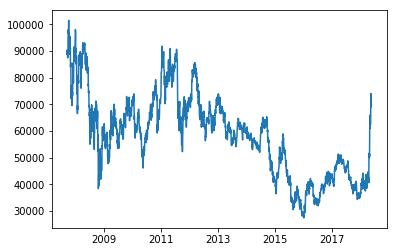

In [484]:
plt.plot(raw_data[stock]['Close'])

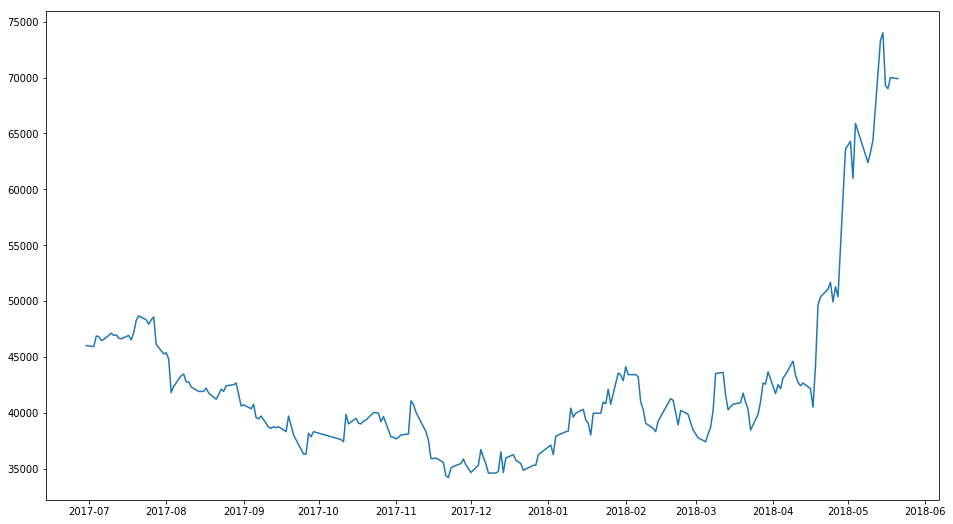

In [487]:
plt.figure(figsize=(16,9))
plt.plot(raw_data[stock]['Close'].loc['2017-06-30':])

In [ ]:
# precision

0.5 1.0379459809992952

0.6 1.0386310337393252

0.7 1.0446957439273685

0.8 1.0417550204629784

0.9 1.0634251690732828